In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sn
import glob
import os
import sys

import plotly.express as px
import seaborn as sns

# Definir carpetas y archivos a utilizar

In [2]:
root_dir = os.path.dirname(os.getcwd())

# Directorios principales
ProcesamientoDatos_dir = os.path.join(root_dir, 'a. Procesamiento de datos')
Estudios_dir = os.path.join(root_dir, 'b. Estudio Correlacion y Sistema')
Simulacion_dir = os.path.join(root_dir, 'c. Simulacion sistema')

# Datos de entrada
Datos_dir = os.path.join(os.path.dirname(root_dir), '1. Datos de entrada')
GenData_dir = os.path.join(Datos_dir, 'Generacion')
datosCEN_dir = os.path.join(GenData_dir, 'Datos_CEN')
CEN_dir = os.path.join(Datos_dir, 'CEN')

# Datos de salida
Output_dir = os.path.join(ProcesamientoDatos_dir, 'Output')

# Archivos de trabajo
IPLP_file = os.path.join(CEN_dir, 'IPLP20240501_mensual.xlsm')
BarrasAsignacion_file = os.path.join(Output_dir, 'BarrasRepresentativas.xlsx')

# SistemaReducido
SistemaReducido_file = os.path.join(Output_dir, 'SistemaReducido.xlsx')

BarrasRepresentativas_file = os.path.join(CEN_dir, 'BarrasRepresentativas.xlsx')

In [3]:
df_BarrasRepresentativas_Asig = pd.read_excel(BarrasRepresentativas_file, sheet_name='Asignacion', header=1, usecols='B:G')

# Leer archivos

In [4]:
df_BarrasAsignacion = pd.read_excel(BarrasAsignacion_file, sheet_name='Asignacion')
df_LineasRed = pd.read_excel(SistemaReducido_file, sheet_name='Lineas')
df_BarrasRed = pd.read_excel(SistemaReducido_file, sheet_name='Barras')

In [5]:
def PreProcessDf(df):
    """
    cols_A = df_L.columns
    cols_B = df_L.iloc[0,:].values
    cols = [cols_B[0], cols_B[1]]
    ant = None
    for A,B in zip(cols_A[2:], cols_B[2:]):
        if not 'Unnamed' in A:
            ant = A
        
        cols.append(f'{ant}_{B}')

    df_L.columns = cols
    # drop first row
    df_L = df_L.drop(0)
    # Manage the merged cells in the first column
    df_L.iloc[:,0] = df_L.iloc[:,0].fillna(method='ffill', axis=0)
    # set index with two first columns
    idx_cols = list(df_L.columns[:2])
    df_L = df_L.set_index(idx_cols)
    """
    cols_A = df.columns
    cols_B = df.iloc[0,:].values
    cols = ["Barras", cols_B[1]]
    ant = None
    for A,B in zip(cols_A[2:], cols_B[2:]):
        if not 'Unnamed' in A:
            ant = A
        cols.append(f'{ant}_{B}')
    df.columns = cols
    # drop first row
    df = df.drop(0)
    # Manage the merged cells in the first column
    df.iloc[:,0] = df.iloc[:,0].fillna(method='ffill', axis=0)
    # set index with two first columns
    idx_cols = list(df.columns[:2])
    df = df.set_index(idx_cols)
    return df


def readIPLP(file):
    df_L = pd.read_excel(file, sheet_name='Demanda-L', header=4)
    df_R = pd.read_excel(file, sheet_name='Demanda-R', header=4)
    df_LD = pd.read_excel(file, sheet_name='Demanda-LD', header=4)
    df_L = PreProcessDf(df_L)
    df_R = PreProcessDf(df_R)
    df_LD = PreProcessDf(df_LD)
    # Sum of the three dataframes
    df_Demanda = df_L + df_R + df_LD
    return df_Demanda

df_Demanda = readIPLP(IPLP_file)

In [6]:
def CrearPerfilSistema(df_Demanda_input):
    df_Demanda = df_Demanda_input.copy()
    Months = [x.split('_')[0] for x in df_Demanda.columns]
    # Remove duplicates
    Months = list(dict.fromkeys(Months))
    for month in Months:
        df_Demanda[month] = (df_Demanda[f'{month}_DO'] + df_Demanda[f'{month}_LU'] + df_Demanda[f'{month}_SA'] + df_Demanda[f'{month}_TR']*4)/7
    df_Demanda = df_Demanda[Months]
    # pivot table so that the columns are the months and hours, and the rows are the buses
    df_Demanda = df_Demanda.stack().reset_index()
    df_Demanda.columns = ['Barras', 'Hora', 'Mes', 'Demanda']
    df_Demanda = df_Demanda.loc[:,['Mes', 'Hora','Barras', 'Demanda']]
    Month_2_Num = {month: i+1 for i, month in enumerate(Months)}
    df_Demanda['Mes'] = df_Demanda['Mes'].map(Month_2_Num)
    df_Demanda.set_index(['Mes', 'Hora', 'Barras'], inplace=True)
    df_Demanda = df_Demanda.unstack()
    # Drop Demanda column
    df_Demanda.columns = df_Demanda.columns.droplevel(0)
    df_Demanda.drop(' ', axis=1, inplace=True)
    
    #df_Demanda = df_Demanda.unstack(level=2)
    return df_Demanda

df_DemandaSistema = CrearPerfilSistema(df_Demanda)

In [7]:
def CrearPerfilReducido(df_DemandaSistema_input, df_BarrasAsignacion):
    df_DemandaSistema = df_DemandaSistema_input.copy()

    Barras_ConDemanda = df_DemandaSistema.columns

    Barras_Representativas = df_BarrasAsignacion['BarraRepresentativa'].unique()
    dfs_BarrasRep = []
    for BarraRep in Barras_Representativas:
        # if BarraRep is null, continue
        if pd.isnull(BarraRep):
            # Create a dataframe with the index of df_DemandaSistema and a column of zeros with the name of BarraRep
            df_Grupo = pd.DataFrame(index=df_DemandaSistema.index, columns=[BarraRep], data=np.zeros(df_DemandaSistema.shape[0]))
        else:
            BarrasGrupo = df_BarrasAsignacion[df_BarrasAsignacion['BarraRepresentativa'] == BarraRep]['BARRA'].values
            BarrasGrupo_ConDemanda = [x for x in BarrasGrupo if x in Barras_ConDemanda]

            if len(BarrasGrupo_ConDemanda) == 0:
                # Create a dataframe with the index of df_DemandaSistema and a column of zeros with the name of BarraRep
                print(f'Barra {BarraRep} no tiene barras asignadas')
                df_Grupo = pd.DataFrame(index=df_DemandaSistema.index, columns=[BarraRep], data=np.zeros(df_DemandaSistema.shape[0]))
            else:
                df_Grupo = df_DemandaSistema.loc[:, BarrasGrupo_ConDemanda]
                df_Grupo = df_Grupo.sum(axis=1).to_frame(name=BarraRep)
        
        dfs_BarrasRep.append(df_Grupo)
    df_DemandaRed = pd.concat(dfs_BarrasRep, axis=1)
    return df_DemandaRed

df_DemandaSistemaReducido = CrearPerfilReducido(df_DemandaSistema, df_BarrasAsignacion)

Barra Cumbre500 no tiene barras asignadas
Barra LosChangos500 no tiene barras asignadas
Barra Kimal500 no tiene barras asignadas


In [8]:
df_BarrasRed

,Unnamed: 0,ID,Barra,Latitud,Longitud,Voltaje
0,0,0,AJahuel500,-33.714759,-70.694261,500
1,1,1,Ancoa500,-35.681860,-71.377217,500
2,2,2,Cumbre500,-26.255953,-69.988115,500
3,3,3,Kimal220,-22.300528,-69.481822,220
4,4,4,Kimal500,-22.300528,-69.481822,500
5,5,5,LoAguirre500,-33.448101,-70.908051,500
6,6,6,LosChangos220,-23.156322,-70.318544,220
7,7,7,LosChangos500,-23.156322,-70.318544,500
8,8,8,NvaCardones500,-27.518674,-70.425981,500
9,9,9,NvaMaitencillo500,-28.542941,-70.928938,500


In [9]:
def CrearDemandaInfo(df_Demanda, df_BarrasRed):
    Demandas = list(df_Demanda.columns)
    dfs_Demandas = []
    for ID,Demanda in enumerate(Demandas):
        Barra_IPLP = Demanda
        Barra_Red = df_BarrasRepresentativas_Asig[df_BarrasRepresentativas_Asig['Barras IPLP'] == Barra_IPLP]['Nombre Reducido'].values[0]
        ID_Barra = df_BarrasRed[df_BarrasRed['Barra'] == Barra_Red]['ID'].values[0]
        dfs_Demandas.append(pd.DataFrame({'ID':ID,'Nombre Demanda': [Barra_IPLP], 'Nombre Barra': [Barra_Red], 'ID_Barra': [ID_Barra]}))
    df_DemandaInfo = pd.concat(dfs_Demandas)
    return df_DemandaInfo
df_Demanda_Info = CrearDemandaInfo(df_DemandaSistemaReducido, df_BarrasRed)

# Calcular el equivalente en p.u

In [10]:
def GetDemandaAnual(df_Demanda: pd.DataFrame) -> float:
    """
    Calcula la demada anual en GWh desde un dataframe de demanda en MW
    """
    DiasMes_dict = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
    df_Energia = df_Demanda.sum(axis=1).to_frame(name='Energia MW').reset_index()
    df_Energia['Energia GWh'] = df_Energia.apply(lambda x: x['Energia MW']*DiasMes_dict[x['Mes']]/1000, axis=1)
    Energia_SEN_GWH = df_Energia['Energia GWh'].sum()
    return Energia_SEN_GWH

def PerfilUnitario(df_DemandaSistemaReducido_input: pd.DataFrame) -> pd.DataFrame:
    """
    Dado un dataframe de demanda en MW, calcula el perfil unitario en base demanda anual GWh
    """
    df_DemandaSistemaReducido = df_DemandaSistemaReducido_input.copy()
    # Calcular la energia total
    Energia_SEN_GWH = GetDemandaAnual(df_DemandaSistemaReducido)
    print(f'Energia SEN: {Energia_SEN_GWH} G')

    # Calcular la energia unitaria
    df_DemandaSistemaReducido_pu = df_DemandaSistemaReducido.div(Energia_SEN_GWH)
    return df_DemandaSistemaReducido_pu

def EscalarDemanda(df_DemandaSistemaReducido_MW_input: pd.DataFrame, DemandaAnual_GWh: float) -> pd.DataFrame:
    """
    Escala el perfil unitario de demanda a una demanda total
    """
    df_DemandaSistemaReducido_pu = PerfilUnitario(df_DemandaSistemaReducido_MW_input)
    df_DemandaSistemaReducido_scaled = df_DemandaSistemaReducido_pu.mul(DemandaAnual_GWh)
    return df_DemandaSistemaReducido_scaled

df_DemandaEscalada = EscalarDemanda(df_DemandaSistemaReducido, 83095.433147)

Energia SEN: 76836.52130280004 G


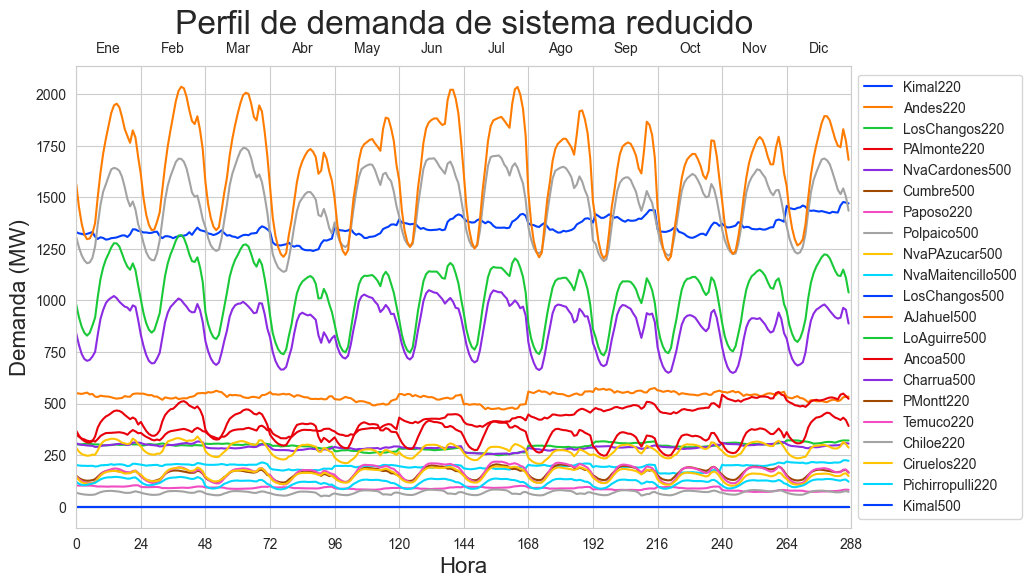

In [11]:
# Graficar los perfiles de demanda
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette("bright", len(df_DemandaEscalada.columns))
for idx,col in enumerate(df_DemandaEscalada.columns):
    ax.plot(df_DemandaEscalada[col].values, label=col, color=colors[idx])
# put the legend outside the plot to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Perfil de demanda de sistema reducido', fontsize=24)
ax.set_xlabel('Hora', fontsize=16)
ax.set_ylabel('Demanda (MW)', fontsize=16)

secx = ax.secondary_xaxis('top')
secx.set_xticks(np.arange(12, 288, 24))
months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
secx.set_xticklabels(months)
secx.tick_params(top = False)

ax.set_xlim(0, 288)
# set the xticks to be every 24 hours
ax.set_xticks(np.arange(0, 289, 24))

plt.show()


In [12]:
# Export to a excel file
with pd.ExcelWriter(os.path.join(Output_dir, 'Perfil Demanda SEN Reducido.xlsx')) as writer:
    df_DemandaEscalada.reset_index().to_excel(writer, sheet_name='Demanda_MW', index=False)

In [13]:
# Export to the file the Sistema Reducido as a new sheet
with pd.ExcelWriter(SistemaReducido_file, mode='a') as writer:
    df_Demanda_Info.to_excel(writer, sheet_name='Demanda_Info', index=False)